In [84]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import librosa
import scipy
import os
from IPython.display import Audio
from scipy.signal import find_peaks
from scipy.signal import butter, sosfilt, sosfreqz
from scipy.integrate import simps
import bisect
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from scipy.fftpack import dct
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.preprocessing import scale
from sklearn.preprocessing import StandardScaler
scale = StandardScaler()
from sklearn.metrics import make_scorer, f1_score
import sounddevice as sd
from scipy.io.wavfile import write
import wavio as wv
from datetime import datetime
import threading
import time
from time import sleep

# Functions for Cough Detection and Extraction

## Data Normalization and Filtering

In [2]:
# Data Normalization

def normalize_data(data):
    min = np.min(data)
    max = np.max(data)

    data = (data - min) / (max - min)
    return data

In [3]:
# Moving Average of the Data:
def compute_moving_average(data, window_size=15):
    
    moving_averages = []

    i = 0
    while i < len(data) - window_size + 1:
        
        window = data[i : i + window_size]
        window_average = round(np.sum(window) / window_size, 2)
        moving_averages.append(window_average)

        i += 1    
    
    return np.array(moving_averages)

In [4]:
# Filtering of the data

def butter_bandpass(lowcut, highcut, fs, order=5):
        nyq = 0.5 * fs
        low = lowcut / nyq
        high = highcut / nyq
        sos = butter(order, [low, high], analog=False, btype='band', output='sos')
        return sos

def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
        sos = butter_bandpass(lowcut, highcut, fs, order=order)
        y = sosfilt(sos, data)
        return y

## Timestamps of the Cough or Other Audio

In [5]:
# Real Cough Timestamps of the Data

def get_real_timestamps(audio_timestamp):

    timestamp = []
    f = open(audio_timestamp, "r")
    content = f.read()
    content = content.split("\n")

    for line in content:
        if line != "":
            timestamp.append(float(line.split("\t")[0]))
    
    return timestamp

## Frequency Domain Sound Extraction Functions

In [6]:
# Summation of the frequency bins in a spectogram

def get_frequency_sums(data):
    
    sums = []
    S_db_tp = np.transpose(mel_spectrogram_db)

    for bin in S_db_tp:
        sums.append(np.sum(bin))

    sums = np.array(sums)

    return sums

In [7]:
def detect_coughs_freq_domain(data, file_path, percentile_threshold = 90):
    
    # Statistics of the data
    max_value = np.max(data)
    mean_value = np.mean(data)
    std = np.std(data)
    data_length = len(data)
    
    # Threshold 
    threshold = np.percentile(data, percentile_threshold)
    
    # Peak detection
    cough_indices, _ = find_peaks(data, prominence = 5)
    cough_indices = list(cough_indices)

    # Deleting overlaps in the peaks - Avoiding to count same cough more than one
    i = 0
    while i < len(cough_indices):

        peak = cough_indices[i]
        peak_range = (peak - 50, peak + 50) # The range is determined experimentally

        overlap_indices = [index for index in cough_indices
                       if peak_range[0] < index < peak_range[1]]

        if len(overlap_indices) > 1:

            # Find the index with maximum amplitude 
            max = overlap_indices[0]
            for index in overlap_indices:
                if (data[index] > data[max]):
                    max = index

            overlap_indices.remove(max)

            for element in overlap_indices:
                cough_indices.remove(element)

        i += 1

    # Applying the threshold
    
    cough_indices_copy = list(cough_indices)
    for index in cough_indices_copy: 
        amplitude = data[index]
        if amplitude < threshold or amplitude < -9250:
            cough_indices.remove(index)


    # Finding the timestamps of the coughs
    predicted_timestamps = [] 
    for index in cough_indices:
        predicted_timestamps.append(round(index / sample_rate, 6))

    # Scaling timestamps according to original recording duration
    duration = librosa.get_duration(path=file_path)
    
    total_samples = duration * sample_rate
    
    for i in range(len(predicted_timestamps)):
        
        actual_index = total_samples * cough_indices[i] / data_length
        actual_timestamp = round(actual_index / sample_rate, 6)
        
        predicted_timestamps[i] = actual_timestamp
    
    
    
    # Filtering the sound after coughing
    for ts in predicted_timestamps:
        match = list((ts_2 for ts_2 in predicted_timestamps if ts < ts_2 < ts + 0.4))
        if len(match) != 0:
            index = predicted_timestamps.index(match[0])
            predicted_timestamps.remove(match[0])
            cough_indices.remove(cough_indices[index])

        
    return cough_indices, predicted_timestamps

## Time Domain Sound Extraction Functions

In [8]:
# Cough Detection Algorithm

def detect_coughs_time_domain(data):
    
    max_value = np.max(data)
    mean_value = np.mean(data)
    std = np.std(data)

    # Threshold 
    percentile_threshold = 90
    threshold = np.percentile(data, percentile_threshold)

    # Peak detection
    cough_indices, _ = find_peaks(data, prominence = 0.3)
    cough_indices = list(cough_indices)

    # Deleting overlaps in the peaks - Avoiding to count same cough more than one
    i = 0
    while i < len(cough_indices):

        peak = cough_indices[i]
        peak_range = (peak - 5000, peak + 5000) # The range is determined experimentally

        overlap_indices = [index for index in cough_indices
                       if peak_range[0] < index < peak_range[1]]

        if len(overlap_indices) > 1:

            # Find the index with maximum amplitude 
            max = overlap_indices[0]
            for index in overlap_indices:
                if (data[index] > data[max]):
                    max = index

            overlap_indices.remove(max)

            for element in overlap_indices:
                cough_indices.remove(element)

        i += 1


    # Applying the threshold
    cough_indices_copy = cough_indices.copy()
    for index in cough_indices_copy:

        amplitude = data[index]

        if (amplitude < threshold):
            cough_indices.remove(index)


    # Finding the timestamps of the coughs
    predicted_timestamps = []
    for index in cough_indices:
        predicted_timestamps.append(round(index / sample_rate, 6))


    # Filtering the sound after coughing
    for ts in predicted_timestamps:
        matches = list((ts_2 for ts_2 in predicted_timestamps if ts < ts_2 < ts + 0.4))

        if len(matches) != 0:
            for i in range(len(matches)):
                index = predicted_timestamps.index(matches[i])
                predicted_timestamps.remove(matches[i])
                cough_indices.remove(cough_indices[index])

    return cough_indices, predicted_timestamps

## Percentile Calculation Functions

In [9]:
def binary_search(auc_values, threshold):
    index = bisect.bisect_left(auc_values, threshold)
    if index < len(auc_values):
        return index
    return None

In [10]:
# Percentile Points of a Signal

def find_percentile_points(signal):
    
        # Calculating Fast Fourier Transform
        X = np.fft.fft(signal)
        X_mag = np.abs(X) / len(signal)

        freqs = np.fft.fftfreq(len(signal), d=1/sample_rate)

        # Graph
        positive_freq_indices = np.where(freqs >= 0)

        # Getting positive part
        freqs = freqs[positive_freq_indices]
        X_mag = X_mag[positive_freq_indices]

        auc = simps(X_mag, freqs)
        per_25 = auc * 0.25
        per_50 = auc * 0.50
        per_75 = auc * 0.75
        per_90 = auc * 0.90

        # Cumulative area
        cumulative_auc = [simps(X_mag[:i+1], freqs[:i+1]) for i in range(len(freqs))]

        # Find the indices for each percentile
        point_1 = binary_search(cumulative_auc, per_25)
        point_2 = binary_search(cumulative_auc, per_50)
        point_3 = binary_search(cumulative_auc, per_75)
        point_4 = binary_search(cumulative_auc, per_90)

        per_25_result = freqs[point_1]
        per_50_result = freqs[point_2]
        per_75_result = freqs[point_3]
        per_90_result = freqs[point_4]
        
        return per_25_result, per_50_result, per_75_result, per_90_result

## MFCC Calculation Function

In [11]:
# MFCC values of a Signal

def get_mfcc_features(signal):
        
    # Original MFCCs
    mfccs = librosa.feature.mfcc(y=signal, sr=sample_rate, n_mfcc=13)


    # First derivative of MFCCs
    delta_mfccs = librosa.feature.delta(mfccs)


    # Second derivative of MFCCs
    delta2_mfccs = librosa.feature.delta(mfccs, order=2)
    
    return mfccs, delta_mfccs, delta2_mfccs

# High Frequency Sound Classification

The extracted sound will be classified as cough or other.

## Data Preparation

In [93]:
# Cough Data
Audiodata = {'percentile_25': [], 'percentile_50': [], 'percentile_75': [], 'percentile_90': [], 'mfcc': [], 'sc':[], 'label': []}

audio_files = os.listdir('./audio-records/cough')
timestamp_files = os.listdir('./audio-records/cough-timestamps')

# Filtering irrelevant files
audio_files = list(filter(lambda x: x.endswith('.wav'), audio_files))
timestamp_files = list(filter(lambda x: x.endswith('.txt'), timestamp_files))

for file in audio_files:
    
    file_name = file.split(".wav")[0]    
    timestamp_files = [file[0:19] for file in timestamp_files]    

    # Finding correspoding timestamp file
    index = timestamp_files.index(file_name)
    timestamp_data = timestamp_files[index]
    
    file_path = './audio-records/cough/' + file
    timestamp_path = './audio-records/cough-timestamps/' + timestamp_data + '-label.txt'

    # Adding timestamps to the list
    real_timestamps = get_real_timestamps(timestamp_path)    
    
    # Loading audio_file
    # Target sample rate: 48000
    data, sample_rate = librosa.load(file_path, sr=48000)

    # Audio duration
    duration = librosa.get_duration(path = file_path)
    total_samples = duration * sample_rate
    time = np.arange(0, len(data)) / sample_rate

    # Filtering data
    data = butter_bandpass_filter(data, 1000, 4000, sample_rate,8)

    # Getting moving average of the data
    moving_avg_data = compute_moving_average(np.abs(data))

    # Normalize the data
    moving_avg_data = normalize_data(moving_avg_data)
    
    
    # *******************************
    # Find coughs in the data
    copy_data = moving_avg_data.copy()
    coughs = []

    for timestamp in real_timestamps:

        start = int((timestamp - 0.2) * sample_rate)
        finish = int((timestamp + 0.2) * sample_rate)

        data = copy_data[start:finish]
        coughs.append(data)

    
    # *******************************
    for cough in coughs:
        # Removing DC component
        cough -= np.mean(cough)

        try:
            
            # Find percentile points
            per_25, per_50, per_75, per_90 = find_percentile_points(cough)

            Audiodata['percentile_25'].append(per_25)
            Audiodata['percentile_50'].append(per_50)
            Audiodata['percentile_75'].append(per_75)
            Audiodata['percentile_90'].append(per_90)


            # MFCC Feature extraction
            mfccs, delta_mfccs, delta2_mfccs = get_mfcc_features(cough)

            # Comprehensive MFCCs
            comprehensive_mfccs = np.concatenate((mfccs, delta_mfccs, delta2_mfccs))
            Audiodata['mfcc'].append(comprehensive_mfccs)
            Audiodata['label'].append('cough')
            
            # Find spectral centroids
            sc = librosa.feature.spectral_centroid(y=cough, sr=sample_rate)
            Audiodata['sc'].append(sc)
        
        except:
            continue
    
# ----------------------------------------------------------------------
# Other Data

audio_files = os.listdir('./audio-records/no-cough')
timestamp_files = os.listdir('./audio-records/no-cough-timestamps')

# Filtering irrelevant files
audio_files = list(filter(lambda x: x.endswith('.wav'), audio_files))
timestamp_files = list(filter(lambda x: x.endswith('.txt'), timestamp_files))

for file in audio_files:

    file_name = file.split(".wav")[0]    
    timestamp_files = [file[0:19] for file in timestamp_files]    

    # Finding correspoding timestamp file
    index = timestamp_files.index(file_name)
    timestamp_data = timestamp_files[index]
    
    file_path = './audio-records/no-cough/' + file
    timestamp_path = './audio-records/no-cough-timestamps/' + timestamp_data + '-label.txt'

    # Adding timestamps to the list
    real_timestamps = get_real_timestamps(timestamp_path)    
    
    # Loading audio_file
    # Target sample rate: 48000
    data, sample_rate = librosa.load(file_path, sr=48000)

    # Audio duration
    duration = librosa.get_duration(path = file_path)
    total_samples = duration * sample_rate
    time = np.arange(0, len(data)) / sample_rate

    # Filtering data
    data = butter_bandpass_filter(data, 1000, 4000, sample_rate,8)

    # Getting moving average of the data
    moving_avg_data = compute_moving_average(np.abs(data))

    # Normalize the data
    moving_avg_data = normalize_data(moving_avg_data)
    
    
    # *******************************
    # Find peaks in the data
    copy_data = moving_avg_data.copy()
    peaks = []

    for timestamp in real_timestamps:

        start = int((timestamp - 0.2) * sample_rate)
        finish = int((timestamp + 0.2) * sample_rate)

        data = copy_data[start:finish]
        peaks.append(data)

    # *******************************
    for peak in peaks:
        # Removing DC component
        peak -= np.mean(peak)

        try:
            
            # Find percentile points
            per_25, per_50, per_75, per_90 = find_percentile_points(peak)

            Audiodata['percentile_25'].append(per_25)
            Audiodata['percentile_50'].append(per_50)
            Audiodata['percentile_75'].append(per_75)
            Audiodata['percentile_90'].append(per_90)

            # MFCC Feature extraction
            mfccs, delta_mfccs, delta2_mfccs = get_mfcc_features(peak)

            # Comprehensive MFCCs
            comprehensive_mfccs = np.concatenate((mfccs, delta_mfccs, delta2_mfccs))
            Audiodata['mfcc'].append(comprehensive_mfccs)
            Audiodata['label'].append('other')
            
            # Find spectral centroids
            sc = librosa.feature.spectral_centroid(y=cough, sr=sample_rate)
            Audiodata['sc'].append(sc)
            
            
        except:
            continue


/Users/zulaldemirtas/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/zulaldemirtas/anaconda3/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


## Training, Validation, and Test Data Preparation

In [94]:
# Converting the Audiodata dictionary into the pandas dataframe

df = pd.DataFrame.from_dict(Audiodata)
print(df.head())

# Both MFCCs and Percentiles
mfcc_values = np.array(df['mfcc'].tolist())
mfcc_values = mfcc_values.reshape(mfcc_values.shape[0], -1)

sc_values = np.array(df['sc'].tolist())
sc_values = sc_values.reshape(sc_values.shape[0], -1)

percentile_values = df.iloc[:, :4].values

# X and y 
X = np.concatenate((percentile_values, mfcc_values, sc_values), axis=1)
y = df.iloc[:, -1]

class_mapping = {'cough': 1, 'other': 0}
y = [class_mapping[label] for label in y]

# Training Data
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state= 3, train_size=0.80)

# Scaling
X_train = scale.fit_transform(X_train)
X_test = scale.fit_transform(X_test)

#-------------------------------------------------------------------------------------------------------
# Only Percentiles

# X_per and y_per
X_per = X[:, :4]
y_per = y

# Training Data
X_train_per, X_test_per, y_train_per, y_test_per = train_test_split(X_per, y_per, random_state= 3, train_size=0.80)

# Scaling
X_train_per = scale.fit_transform(X_train_per)
X_test_per = scale.fit_transform(X_test_per)

   percentile_25  percentile_50  percentile_75  percentile_90  \
0          305.0          980.0         2575.0         7440.0   
1          315.0          970.0         2815.0         8190.0   
2          290.0          835.0         2400.0         5565.0   
3          272.5          910.0         2610.0         9690.0   
4          350.0          970.0         2705.0         8565.0   

                                                mfcc  \
0  [[-356.39807589073223, -424.07034764773715, -6...   
1  [[-361.44165227976464, -429.1139240367695, -71...   
2  [[-340.7079535361824, -408.3802252931873, -660...   
3  [[-265.8783977598816, -333.5506695168865, -633...   
4  [[-260.61854422791487, -328.2908159849198, -62...   

                                                  sc  label  
0  [[2861.848763575088, 1762.9879480579157, 7.812...  cough  
1  [[2861.8487635750885, 1762.9879480579157, 7.81...  cough  
2  [[2861.8487635750894, 1762.9879480579164, 7.81...  cough  
3  [[2861.84876357509, 1

## K-Nearest Neighbors Model

Best Parameters: {'n_neighbors': 4, 'weights': 'uniform'}
F1 Score: 0.96


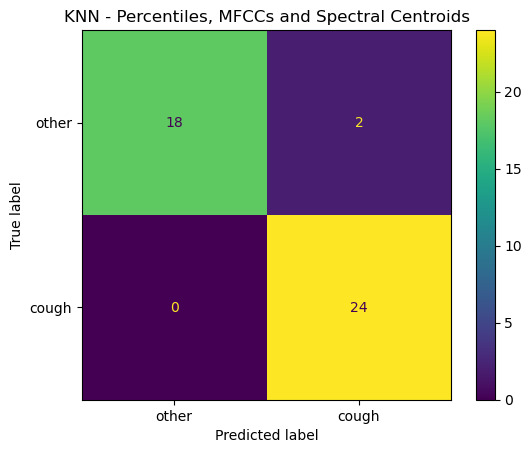

Best Parameters: {'n_neighbors': 27, 'weights': 'distance'}
F1 Score: 0.8979591836734694


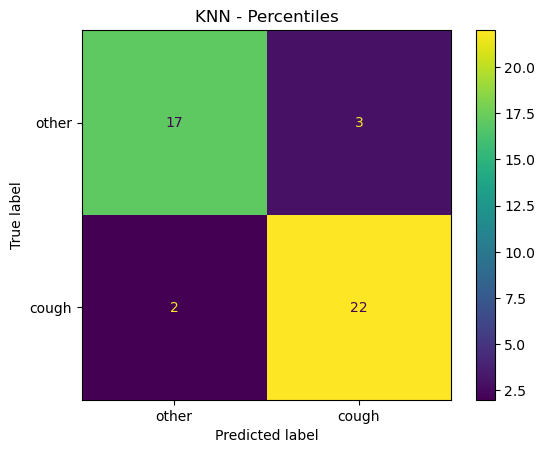

In [97]:
# KNN - Percentiles and MFCCs Combined

# Train the model using the training set
clf_knn = KNeighborsClassifier(p=2)

# Hyperparameter tuning based on the validation performance
param_grid = {
    'n_neighbors': list(range(3, int(len(X_train) * 0.65))),
    'weights': ['uniform', 'distance']
}

# GridSearchCV
grid_search = GridSearchCV(estimator = clf_knn, 
                           param_grid = param_grid, 
                           cv = 3, 
                           scoring = 'f1')

grid_search.fit(X_train, y_train)
best_params = grid_search.best_params_

print("Best Parameters: {}".format(best_params))
clf_knn = KNeighborsClassifier(**best_params)
clf_knn.fit(X_train, y_train)

y_pred = clf_knn.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("F1 Score: {}".format(f1))
display_labels = ['other', 'cough']
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=display_labels)
disp.plot()
plt.title("KNN - Percentiles, MFCCs and Spectral Centroids")
plt.show()


#---------------------------------------------------------------------------------------------------------

# KNN - Only Percentiles
# Define the model

grid_search.fit(X_train_per, y_train_per)
best_params_per = grid_search.best_params_

print("Best Parameters: {}".format(best_params_per))
clf_knn_per = KNeighborsClassifier(**best_params_per)
clf_knn_per.fit(X_train_per, y_train_per)

y_pred_per = clf_knn_per.predict(X_test_per)
cm_per = confusion_matrix(y_test_per, y_pred_per)
f1_per = f1_score(y_test_per, y_pred_per)

print("F1 Score: {}".format(f1_per))
disp = ConfusionMatrixDisplay(confusion_matrix=cm_per, display_labels=display_labels)
disp.plot()
plt.title("KNN - Percentiles")
plt.show()

## Support Vector Machine Model

Best Parameters: {'C': 10, 'gamma': 0.0001, 'kernel': 'rbf'}
F1 Score: 0.9795918367346939


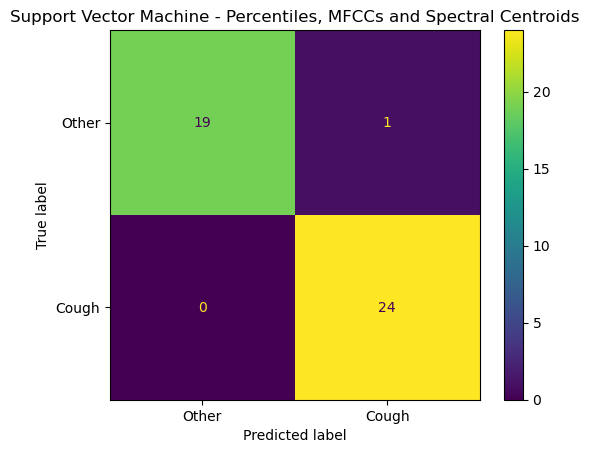

Best Parameters: {'C': 100, 'gamma': 0.1, 'kernel': 'rbf'}
F1 Score: 0.9565217391304348


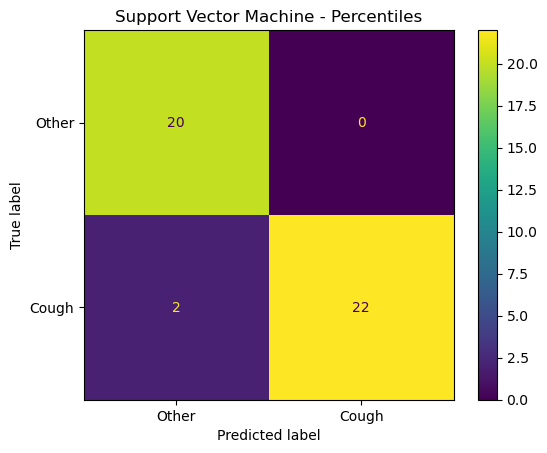

In [99]:
# Support Vector Machine

# Optimize the parameters
# Finding the best value for gamma and regularization parameter

# C: regularization parameter
param_grid = [
    {
    'C': [0.5, 1, 10, 100],
    'gamma': ['scale', 1, 0.1, 0.01, 0.001, 0.0001],
    'kernel': ['rbf']
    },
]

optimal_params = GridSearchCV(
    SVC(),
    param_grid,
    cv=3,
    scoring='f1'
)

optimal_params.fit(X_train, y_train)
C = optimal_params.best_params_['C']
gamma = optimal_params.best_params_['gamma']
print("Best Parameters: {}".format(optimal_params.best_params_))

# Model Training and Prediction
clf_svm = SVC(random_state=42, C=C, gamma=gamma)
clf_svm.fit(X_train, y_train)

y_pred = clf_svm.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("F1 Score: {}".format(f1))

display_labels = ['Other', 'Cough']
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=display_labels)
disp.plot()
plt.title("Support Vector Machine - Percentiles, MFCCs and Spectral Centroids")
plt.show()


# Only percentiles

optimal_params.fit(X_train_per, y_train_per)
C = optimal_params.best_params_['C']
gamma = optimal_params.best_params_['gamma']
print("Best Parameters: {}".format(optimal_params.best_params_))

clf_svm_per = SVC(random_state=42, C=C, gamma=gamma)
clf_svm_per.fit(X_train_per, y_train_per)

y_pred_per = clf_svm_per.predict(X_test_per)
cm_per = confusion_matrix(y_test_per, y_pred_per)
f1_per = f1_score(y_test_per, y_pred_per)

print("F1 Score: {}".format(f1_per))

disp = ConfusionMatrixDisplay(confusion_matrix=cm_per, display_labels=display_labels)
disp.plot()
plt.title("Support Vector Machine - Percentiles")
plt.show()

## Spectrograms and CNNs

# Prediction of Cough Count with Recording

In [100]:
# File name format
current_time = datetime.now()
formatted_time = current_time.strftime("%Y-%m-%dT%H-%M-%S")

directory = "./audio-records/test-recordings/"
filename = os.path.join(directory, f"{formatted_time}.wav")

def timer(duration):
    for remaining in range(duration, 0, -1):
        print(f"Time remaining: {remaining} seconds", end='\r')
        sleep(1)
    print("\nRecording finished.")

# Sampling frequency
freq = 48000
 
# Recording duration
duration = 60
 
print("Recording started...")
timer_thread = threading.Thread(target=timer, args=(duration,))
timer_thread.start()

recording = sd.rec(int(duration * freq), 
                   samplerate=freq, channels=1, dtype='int16')
 
# Record audio for the given number of seconds
sd.wait()
timer_thread.join()

# Convert the NumPy array to audio file
wv.write(filename, recording, freq, sampwidth=2)

Recording started...
Time remaining: 1 secondss
Recording finished.


In [101]:
# Cough audio loading

# Target sample rate: 48000
data, sample_rate = librosa.load(filename, sr=48000)

Audio(filename)

## Sound Extraction - Based on Time and Frequency Domain

Frequency Domain Predicted Timestamps: [2.154667, 36.928]
Time Domain Predicted Timestamps: [2.157542, 36.919688]
[2.154667, 36.928]


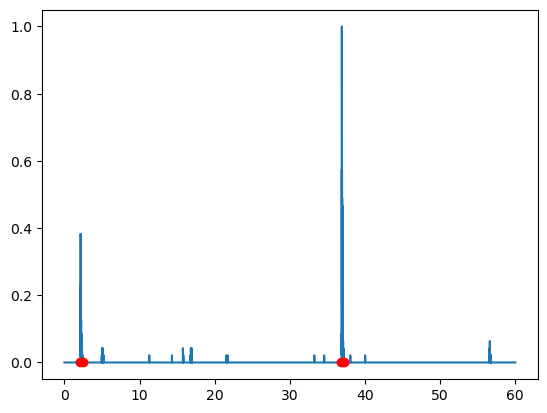

In [102]:
# Extraction of high frequency signals (cough/other) from the audio
audio_peak_extractions = []

# Audio duration
duration = librosa.get_duration(path = filename)
total_samples = duration * sample_rate

# Filtering data
data = butter_bandpass_filter(data, 1000, 4000, sample_rate, 8)

# Getting moving average of the data
moving_avg_data = compute_moving_average(np.abs(data))

# Normalize the data
normalized_moving_avg_data = normalize_data(moving_avg_data)

# Time 
time = np.arange(0, len(normalized_moving_avg_data)) / sample_rate

# Getting melspectrogram
mel_spectrogram = librosa.feature.melspectrogram(y=normalized_moving_avg_data, sr=sample_rate)
mel_spectrogram_db = librosa.amplitude_to_db(mel_spectrogram, ref=np.max)    

frequency_sums = get_frequency_sums(mel_spectrogram_db)

# Detection of high frequency sounds - peaks (Based on frequency domain)
peak_indices_freq , predicted_timestamps_freq = detect_coughs_freq_domain(frequency_sums, filename)
print("Frequency Domain Predicted Timestamps: {}".format(predicted_timestamps_freq))

# Detection of sounds with high magnitude (Based on time domain)
peak_indices_time , predicted_timestamps_time = detect_coughs_time_domain(normalized_moving_avg_data)
print("Time Domain Predicted Timestamps: {}".format(predicted_timestamps_time))

predicted_timestamps = []

for timestamp in predicted_timestamps_freq:

    if any(timestamp - 0.15 < element < timestamp + 0.15 for element in predicted_timestamps_time):

        predicted_timestamps.append(timestamp)

print(predicted_timestamps)
plt.plot(time, normalized_moving_avg_data)
for timestamp in predicted_timestamps:

    start = int((timestamp - 0.1) * sample_rate)
    finish = int((timestamp + 0.3) * sample_rate)

    plt.scatter([time[start],time[finish]], [0,0], color='red', zorder=5)    
    audio_peak_extractions.append((normalized_moving_avg_data[start:finish], timestamp))

    
plt.show()

### Prediction with KNN

KNN Combined (Percentiles + MFCCs): ['cough' 'cough']
Predicted Cough Count: 2
Predicted Cough Timestamps: [2.155, 36.928]


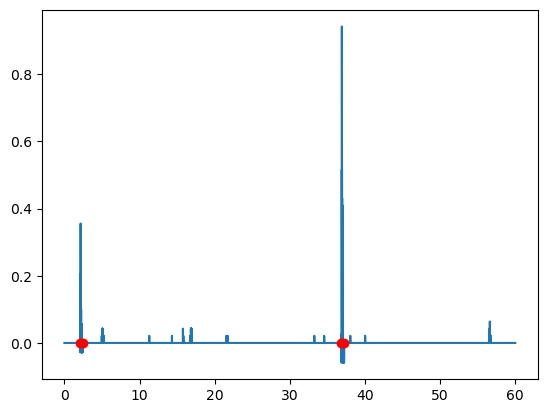

In [107]:
# K-Nearest Neighbors

predicted_timestamps_knn = []
Audiodata_new = {'percentile_25': [], 'percentile_50': [], 'percentile_75': [], 'percentile_90': [], 'mfcc': [], 'sc': []}

# Find percentile points
for peak, timestamp in audio_peak_extractions:

    predicted_timestamps_knn.append(timestamp)

    # Removing DC component
    peak -= np.mean(peak)

    per_25, per_50, per_75, per_90 = find_percentile_points(peak)

    Audiodata_new['percentile_25'].append(per_25)
    Audiodata_new['percentile_50'].append(per_50)
    Audiodata_new['percentile_75'].append(per_75)
    Audiodata_new['percentile_90'].append(per_90)

    # MFCC Feature extraction
    mfccs, delta_mfccs, delta2_mfccs = get_mfcc_features(peak)

    # Comprehensive MFCCs
    comprehensive_mfccs = np.concatenate((mfccs, delta_mfccs, delta2_mfccs))
    Audiodata_new['mfcc'].append(comprehensive_mfccs)
    
    # Find spectral centroids
    sc = librosa.feature.spectral_centroid(y=cough, sr=sample_rate)
    Audiodata_new['sc'].append(sc)

df_test = pd.DataFrame.from_dict(Audiodata_new)

# Both MFCCs and Percentiles
mfcc_values = np.array(df_test['mfcc'].tolist())
mfcc_values = mfcc_values.reshape(mfcc_values.shape[0], -1)

sc_values = np.array(df_test['sc'].tolist())
sc_values = sc_values.reshape(sc_values.shape[0], -1)

percentile_values = df_test.iloc[:, :4].values
test_data = np.concatenate((percentile_values, mfcc_values, sc_values), axis=1)
test_data = scale.fit_transform(test_data)

# Prediction is based on percentiles and mfccs
predictions_knn = clf_knn.predict(test_data)
predictions_knn = np.where(predictions_knn == 1, "cough", "other")

print("KNN Combined (Percentiles + MFCCs): {}".format(predictions_knn))
predicted_timestamps_cough = []

for i in range(len(predictions_knn)):
    if (predictions_knn[i] == 'cough'):

        predicted_timestamps_cough.append(round(predicted_timestamps[i],3))

plt.plot(time, normalized_moving_avg_data)
for timestamp in predicted_timestamps_cough:

    start = int((timestamp - 0.1) * sample_rate)
    finish = int((timestamp + 0.3) * sample_rate)    
    plt.scatter([time[start],time[finish]], [0,0], color='red', zorder=5)    

print("Predicted Cough Count: {}".format(np.where(predictions_knn == 'cough')[0].shape[0]))
print("Predicted Cough Timestamps: {}".format(predicted_timestamps_cough))

### Prediction with Support Vector Machine

SVM Combined (Percentiles + MFCCs): ['cough' 'cough']
Predicted Cough Count: 2
Predicted Cough Timestamps: [2.154667, 36.928]


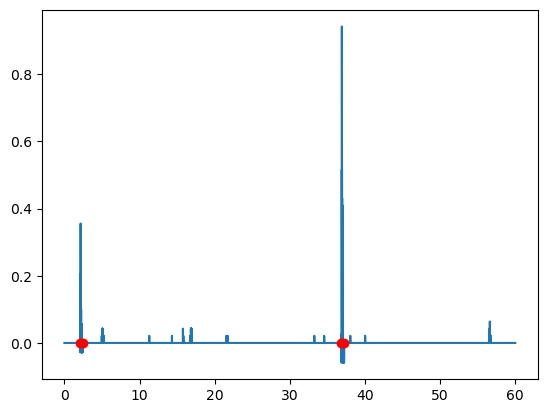

In [109]:
# Support Vector Machine

predicted_timestamps_svm = []
Audiodata_new_svm = {'percentile_25': [], 'percentile_50': [], 'percentile_75': [], 'percentile_90': [], 'mfcc': [], 'sc': []}

# Find percentile points
for peak, timestamp in audio_peak_extractions:

    predicted_timestamps_svm.append(timestamp)

    # Removing DC component
    peak -= np.mean(peak)

    per_25, per_50, per_75, per_90 = find_percentile_points(peak)

    Audiodata_new_svm['percentile_25'].append(per_25)
    Audiodata_new_svm['percentile_50'].append(per_50)
    Audiodata_new_svm['percentile_75'].append(per_75)
    Audiodata_new_svm['percentile_90'].append(per_90)

    # MFCC Feature extraction
    mfccs, delta_mfccs, delta2_mfccs = get_mfcc_features(peak)

    # Comprehensive MFCCs
    comprehensive_mfccs = np.concatenate((mfccs, delta_mfccs, delta2_mfccs))
    Audiodata_new_svm['mfcc'].append(comprehensive_mfccs)
    
    # Find spectral centroids
    sc = librosa.feature.spectral_centroid(y=cough, sr=sample_rate)
    Audiodata_new_svm['sc'].append(sc)


df_test_svm = pd.DataFrame.from_dict(Audiodata_new_svm)

# Both MFCCs and Percentiles
mfcc_values = np.array(df_test_svm['mfcc'].tolist())
mfcc_values = mfcc_values.reshape(mfcc_values.shape[0], -1)

sc_values = np.array(df_test_svm['sc'].tolist())
sc_values = sc_values.reshape(sc_values.shape[0], -1)

percentile_values = df_test_svm.iloc[:, :4].values
test_data_svm = np.concatenate((percentile_values, mfcc_values, sc_values), axis=1)
test_data_svm = scale.fit_transform(test_data_svm)

# Prediction is based on percentiles and mfccs
predictions_svm = clf_svm.predict(test_data_svm)
predictions_svm = np.where(predictions_svm == 0, "other", "cough")

print("SVM Combined (Percentiles + MFCCs): {}".format(predictions_svm))
predicted_timestamps_cough_svm = []

for i in range(len(predictions_svm)):
    if (predictions_svm[i] == 'cough'):
        predicted_timestamps_cough_svm.append(predicted_timestamps_svm[i])

plt.plot(time, normalized_moving_avg_data)
for timestamp in predicted_timestamps_cough_svm:

    start = int((timestamp - 0.1) * sample_rate)
    finish = int((timestamp + 0.3) * sample_rate)
    plt.scatter([time[start],time[finish]], [0,0], color='red', zorder=5)    


print("Predicted Cough Count: {}".format(np.where(predictions_svm == 'cough')[0].shape[0]))
print("Predicted Cough Timestamps: {}".format(predicted_timestamps_cough_svm))